# Perfoming both:

1 pixel level 2d balmer decrement calculation

2 profiles from elliptical annulei photometry

In [1]:
from    astropy.table       import Table
from    scripts.tools       import *
import  numpy               as     np
from    astropy.io          import fits
from    astropy.cosmology   import Planck18
import  astropy.units       as     u
from    scipy.constants     import arcsec
import  matplotlib.pyplot   as     plt
import  matplotlib.colors   as     colors  
import  matplotlib
from    functools           import reduce
from    tqdm.notebook                import tqdm
import  gc                                         
import  warnings
from    scripts.tools       import *
from    scripts.packman     import *
import  sys, os
from    IPython.display     import clear_output
from    time                import sleep
from    astropy.wcs         import WCS
from    photutils.aperture  import EllipticalAnnulus, EllipticalAperture, aperture_photometry, CircularAperture, CircularAnnulus



warnings.filterwarnings("ignore")
# Avoid division by zero
np.errstate(divide='ignore', invalid='ignore')
warnings.filterwarnings("ignore", message="marker is redundantly defined")

# 1 pixel level balmer decrement

In [42]:
#calculate distance of each pixel to center:
def pixel_to_center_distance(pixel_length):
    y,x = np.indices((50,50))
    center = (np.array((50,50)) - 1) / 2
    distance = np.sqrt((x - center[1])**2 + (y - center[0])**2)
    return (distance*pixel_length).value

#this is the joint function that:
#1. calculate the 2d map of balmer decrement + error
#calculate each pixel distance using redshift + return a table of balmer decrement vs distance
def extract_radial_profile(obj,
                            LINE_HA='LINE_HA',LINE_HB='LINE_HB_CONV',
                            LINEWHT_HA='LINEWHT_HA',LINEWHT_HB='LINEWHT_HB_CONV'):
    try:
        if os.path.exists(f"data_extracted/{file_name(obj,prefix='rad')}"):
            return f"{obj['subfield']}-{obj['ID']} already processed, skipping."
        #load corresponding extracted file
        path = f"data_extracted/{file_name(obj,'extracted')}"
        with fits.open(path,mode='update') as extracted:

            #seg ha hb from extracted data
            seg = find_data('SEG',extracted)[1].data == obj['ID']
            ha  = find_data(LINE_HA,extracted)[1]
            hb  = find_data(LINE_HB,extracted)[1]
            err_ha = find_data(LINEWHT_HA,extracted)[1].data**(-0.5)
            err_hb = find_data(LINEWHT_HB,extracted)[1].data**(-0.5)
            #this mask out all the the negative pixel due to continium oversubtraction
            mask1 = np.logical_and(find_data('LINE_HA',extracted)[1].data>0, find_data('LINE_HB',extracted)[1].data>0)
            mask2 = np.logical_and(ha.data>0,hb.data>0)
            mask  = np.logical_and(np.logical_and(mask1,mask2),seg)

            #pixel length from redshift, !! here angular diameter distance is used
            pixel_length = ha.header['PIXASEC'] * arcsec * Planck18.angular_diameter_distance(obj['z_MAP']).to(u.kpc)
            distances  = pixel_to_center_distance(pixel_length)[mask]
            sort = np.argsort(distances)
            #this gives the distance sorted out.
            distances = distances[sort]
            
            #this part calculate the actual 2d balmer decrement + error
            balmer_2d     = fits.ImageHDU(data = ha.data/hb.data,name = '2D_BALMER')
            #error propagation for balmer decrement
            balmer_2d_err = fits.ImageHDU(data = (err_ha**2/hb.data**2 + ha.data**2 * err_hb**2/hb.data**2)**0.5,name = '2D_BALMER_ERR')


            ha_pix = ha.data[mask][sort]
            hb_pix = hb.data[mask][sort]
            ha_pix_err = err_ha[mask][sort]
            hb_pix_err = err_hb[mask][sort]
            balmer_pix     = balmer_2d.data[mask][sort]
            balmer_pix_err = balmer_2d_err.data[mask][sort]

            dtype = [('DISTANCE [kpc]', 'f4'), ('ha', 'f4'), ('ha_err', 'f4'), ('hb', 'f4'), ('hb_err', 'f4'), ('balmer', 'f4'), ('balmer_err', 'f4')]
            name = f'PIX_RAD_PROFILE'
            balmer_table = fits.BinTableHDU(np.array(list(zip(distances, ha_pix, ha_pix_err, hb_pix, hb_pix_err, balmer_pix, balmer_pix_err)), dtype=dtype), name=name)
            #this is the distance sorted out
            #save update
            save_update(balmer_2d,extracted)
            save_update(balmer_2d_err,extracted)
            #save_update(balmer_table,extracted)
            extracted.flush()
            balmer_table.writeto(f"data_extracted/{file_name(obj,prefix='rad')}", overwrite=True)
        return f"{obj['subfield']}-{obj['ID']} processed"
    except Exception as e:
        print(f"Error processing {obj['subfield']}-{obj['ID']}: {e}")
        return f"{obj['subfield']}-{obj['ID']} error: {e}"

from    concurrent.futures  import ThreadPoolExecutor, as_completed
def cat_process(obj_lis, max_threads=1):
        results = []
        if max_threads > 1 :
            with ThreadPoolExecutor(max_threads) as executor:
                futures = {executor.submit(
                    extract_radial_profile,
                    obj): obj for obj in obj_lis}
                for future in tqdm(as_completed(futures), total=len(obj_lis), desc="Processing"):
                    results.append(future.result())
            return results
        else:
            for obj in tqdm(obj_lis):
                results.append(extract_radial_profile(obj))
            return results

def main():
    obj_lis = Table.read('obj_lis_selected.fits')
    results = cat_process(obj_lis, max_threads=1)
    errorcounting(results)

if __name__ == '__main__' :
    main()

 15%|█▍        | 50/336 [00:09<00:52,  5.44it/s]

Error processing GN7-22746: 'NoneType' object is not subscriptable


100%|██████████| 336/336 [02:38<00:00,  2.12it/s]

total number of obj processed: 336
number of failed obj 1


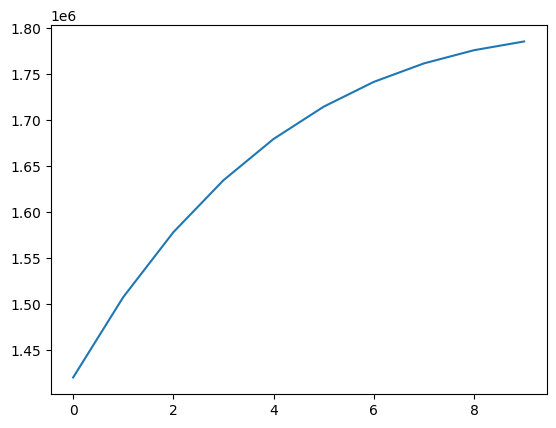

In [145]:
redshift = np.linspace(0.6,1.4,10)
#pixels = np.linspace()
plt.plot(Planck18.angular_diameter_distance(redshift).to(u.kpc))

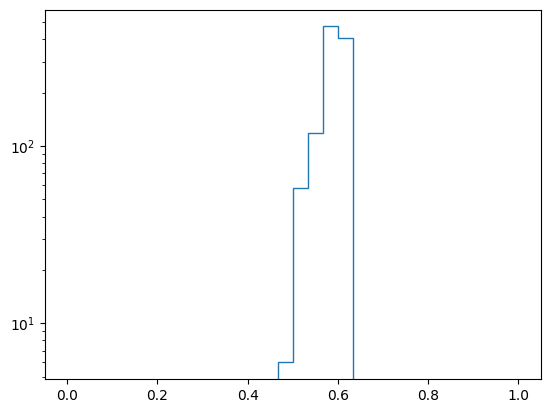

In [147]:
plt.hist(r_lis,histtype='step',bins=30,range=(0,1))
plt.yscale('log')

Error processing GN7-22746: [Errno 2] No such file or directory: 'data_extracted/hlsp_clear_hst_wfc3_gn7-22746_g102-g141_v4_rad.fits'


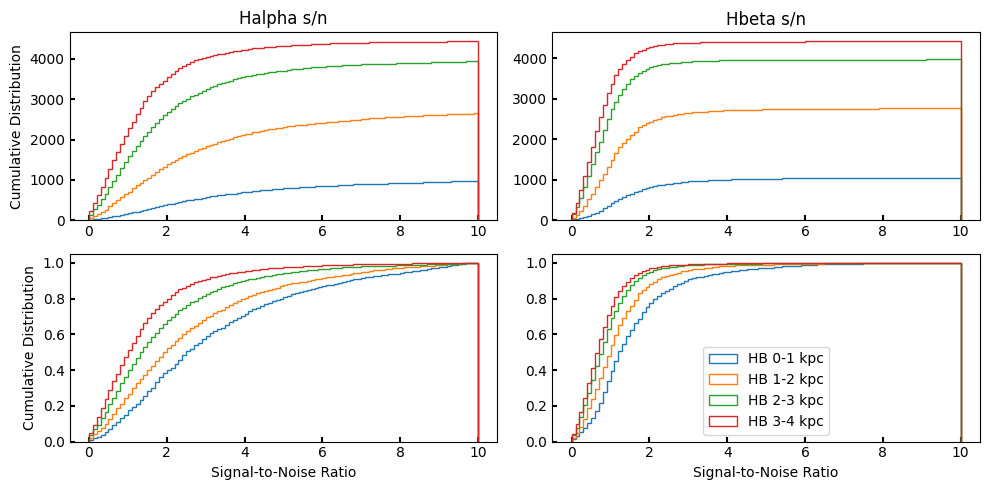

In [58]:
obj_lis = Table.read('obj_lis_selected.fits')
sn_ha = np.array([])
sn_hb = np.array([])
r_lis = np.array([])
for obj in obj_lis:
    try:
        with fits.open(f"data_extracted/{file_name(obj,prefix='rad')}", mode='update') as hdu:
            table = hdu[1]
            r, ha, ha_err, hb, hb_err, balmer, balmer_err = table.data['DISTANCE [kpc]'], table.data['ha'], table.data['ha_err'], table.data['hb'], table.data['hb_err'], table.data['balmer'], table.data['balmer_err']
            sn_ha = np.append(sn_ha, ha / ha_err)
            sn_hb = np.append(sn_hb, hb / hb_err)
            r_lis = np.append(r_lis, r)
    except Exception as e:
        print(f"Error processing {obj['subfield']}-{obj['ID']}: {e}")
        continue

plt.figure(figsize=(10, 5))
#first subplot
for r_range in [[0,1],[1,2],[2,3],[3,4]]:
    mask = (r_lis >= r_range[0]) & (r_lis < r_range[1])
    plt.subplot(2, 2, 1)
    plt.title('Halpha s/n')
    plt.hist(sn_ha[mask], bins=100, cumulative=True, histtype='step', label=f'HA {r_range[0]}-{r_range[1]} kpc',range=(0,10))#,density=True)
    plt.ylabel('Cumulative Distribution')
    plt.subplot(2,2,3)
    plt.hist(sn_ha[mask], bins=100, cumulative=True, histtype='step', label=f'HA {r_range[0]}-{r_range[1]} kpc',range=(0,10),density=True)


plt.xlabel('Signal-to-Noise Ratio')
plt.ylabel('Cumulative Distribution')
#second subplot
for r_range in [[0,1],[1,2],[2,3],[3,4]]:
    mask = (r_lis >= r_range[0]) & (r_lis < r_range[1])
    plt.subplot(2, 2, 2)
    plt.title('Hbeta s/n')
    plt.hist(sn_hb[mask], bins=100, cumulative=True, histtype='step', label=f'HB {r_range[0]}-{r_range[1]} kpc',range=(0,10))#,density=True)
    plt.subplot(2,2,4)
    plt.hist(sn_hb[mask], bins=100, cumulative=True, histtype='step', label=f'HB {r_range[0]}-{r_range[1]} kpc',range=(0,10),density=True)

    plt.legend()
plt.xlabel('Signal-to-Noise Ratio')
plt.tight_layout()

# 2 Photometry using elliptical annulei

In [18]:
#we try to generate a series of elliptial annuli to perfom aperture photometry
def ellip_aperture_series(obj, linemap):
    # The axis ratio
    q = obj['q']
    # The position angle
    pa = obj['pa']
    # The center of the object
    center = ((linemap.data.shape[0]-2) / 2, (linemap.data.shape[1]-2) / 2)
    # We now generate a series of elliptical annuli with the same width
    r = np.linspace(0, linemap.data.shape[0]/2, int((linemap.data.shape[0]+1)/2))
    r = r[r/q < ((linemap.data.shape[0]-1)/2)] 
    if True:
        center_annuli = [EllipticalAperture(center, r[1]/q, r[1] , theta= -(90-pa) * u.deg.to(u.rad))]
        ellip_annuli = [EllipticalAnnulus(center, a_in=r[i]/q, a_out=r[i+1]/q, b_in=r[i], b_out=r[i+1], theta= -(90 -pa) * u.deg ) for i in range(1, len(r)-1)]
        final_aperture = center_annuli + ellip_annuli
    return r, final_aperture

def radial_profile(obj, linemap, weight, seg, pixel_length,ha=False):
    print(f"Processing {obj['subfield']}-{obj['ID']} for radial profile extraction")
    # Here we try to use elliptical annuli to extract the radial profile
    # The semi major axis in arcsec, transformed to pixel:
    r, final_aperture = ellip_aperture_series(obj, linemap)
    # Initialize arrays to store the results
    ha_r = np.zeros(len(final_aperture))
    ha_r_err = np.zeros(len(final_aperture))
    seg_out = np.logical_or(seg != obj['ID'],linemap.data<=0)
    # Mask to select the object
    #if ha:
    #    mask_pack = double_packman(linemap.data.shape[0],90,45)
    #    mask = np.logical_or(seg_out,mask_pack)
    #else:
    #    mask_pack = double_packman(linemap.data.shape[0],90,45)
    #    mask = np.logical_or(seg_out,mask_pack)      
    #mask_pack = double_packman(linemap.data.shape[0],90,45)
    mask = np.logical_or(seg_out,linemap.data <= 0)

    # Calculate the area of each annulus
    surface_area = [aperture.area_overlap(linemap.data,mask=mask,method='subpixel',subpixels=4) for aperture in final_aperture]

    error_data = np.where(weight.data  > 0, weight.data**-0.5, np.nan)
    error_data[np.isinf(error_data)] = np.nan

    # Loop over each annulus and calculate the surface brightness
    for i, annulus in enumerate(final_aperture):
        phot_table = aperture_photometry(linemap.data, annulus, error=weight.data**-0.5, mask=mask, method='subpixel', subpixels=4)
        ha_r[i] = phot_table['aperture_sum'][0]/surface_area[i]
        ha_r_err[i] = phot_table['aperture_sum_err'][0]/surface_area[i]  
    clear_output(wait=True)
    return r*pixel_length, ha_r, ha_r_err


#this function will generate the             print(r, ha_r, ha_r_err, hb_r, hb_r_err, balmer_r, balmer_r_err)
#radial table for a given object
def gen_radial_table_ellip(obj,
                     LINE_HA='LINE_HA',      LINE_HB='LINE_HB_CONV',
                     LINEWHT_HA='LINEWHT_HA',LINEWHT_HB='LINEWHT_HB_CONV'):
    try:
        #print(f"Processing {obj['subfield']}-{obj['ID']} ")
        path = f"data_extracted/{file_name(obj,prefix='extracted')}"
        with fits.open(path,mode='update') as hdu:
            table_name = 'RAD_PROFILE_ELLIP'
            #check if the file already has the radial table
            #if find_data(table_name,hdu) != None:
            #    return f"{obj['subfield']}-{obj['ID']} already exists"
            
            if find_data('SEG_MOD',hdu) != None:
                seg_map = find_data('SEG_MOD',hdu)[1].data
            else:
                seg_map = find_data('SEG',hdu)[1].data

            #extract the radial profile surface brightness
            r, ha_r, ha_r_err = radial_profile(obj,
                                            linemap      = find_data(LINE_HA,hdu)[1],
                                            weight       = find_data(LINEWHT_HA,hdu)[1],
                                            seg          = seg_map,
                                            pixel_length = obj['pixel_length'],
                                            ha           = True)      
            
            r, hb_r, hb_r_err = radial_profile(obj,
                                            linemap      = find_data(LINE_HB,hdu)[1],
                                            weight       = find_data(LINEWHT_HB,hdu)[1],
                                            seg          = seg_map,
                                            pixel_length = obj['pixel_length'])

            #r, balmer_r_pix, balmer_r_pix_err = radial_profile(obj,
            #                                linemap      = find_data('2D_BALMER',hdu)[1],
            #                                weight       = find_data('2D_BALMER_ERR',hdu)[1],
            #                                seg          = seg_map,
            #                                pixel_length = obj['pixel_length'])

            #calculate the balmer decrement
            balmer_r     = ha_r/hb_r
            balmer_r_err =  balmer_r * np.sqrt((ha_r_err / ha_r) ** 2 + (hb_r_err / hb_r) ** 2)
            
            #now calculate the extinction
            #color excess
            E_ba = 2.5*np.log10(balmer_r/2.86)
            #attenutation
            A_ba = E_ba/(K_lambda('Hb')-K_lambda('Ha')) * K_lambda('Ha')


            #E_pix = 2.5*np.log10(balmer_r_pix/2.86)
            #A_pix = E_pix/(K_lambda('Hb')-K_lambda('Ha')) * K_lambda('Ha')

            #columns for the radial table
            cols = [
                fits.Column(name='DISTANCE [kpc]',                       format='E', array=r),
                fits.Column(name='Ha_SURF_BRIGHT [1e-17 erg/s/cm2]',     format='E', array=ha_r),
                fits.Column(name='Ha_SURF_BRIGHT_err [1e-17 erg/s/cm2]', format='E', array=ha_r_err),
                fits.Column(name='Hb_SURF_BRIGHT [1e-17 erg/s/cm2]',     format='E', array=hb_r),
                fits.Column(name='Hb_SURF_BRIGHT_err [1e-17 erg/s/cm2]', format='E', array=hb_r_err),
                fits.Column(name='BALMER_DECREM',                        format='E', array=balmer_r),
                fits.Column(name='BALMER_DECREM_ERR',                    format='E',array=balmer_r_err),
                fits.Column(name='E_BV',                                  format='E', array=E_ba),
                fits.Column(name='A_Ha',                                  format='E', array=A_ba)
            ]
            new_table = fits.BinTableHDU.from_columns(cols, name=table_name)
            #save or update table
            save_update(new_table,hdu)
            #save_update(new_table_pix,hdu)
            hdu.flush()
            return f"{obj['subfield']}-{obj['ID']} processed"
    except Exception as e:
            return f"! {obj['subfield']}-{obj['ID']} failed, error{e}"

def cat_process(obj_lis,
                LINE_HA,   LINE_HB,
                LINEWHT_HA, LINEWHT_HB,
                max_threads=1):
        print(f'start process,{LINE_HA},{LINE_HB}')
        results = []
        if max_threads > 1 :
            with ThreadPoolExecutor(max_threads) as executor:
                futures = {executor.submit(
                    gen_radial_table_ellip,
                    obj,LINE_HA,LINE_HB,LINEWHT_HA,LINEWHT_HB
                                            ): obj for obj in obj_lis}
                for future in tqdm(as_completed(futures), total=len(obj_lis), desc="Processing"):
                    results.append(future.result())
            return results
        else:
            for obj in tqdm(obj_lis):
                results.append(gen_radial_table_ellip(obj,LINE_HA,LINE_HB,LINEWHT_HA,LINEWHT_HB))
            return results


def main():
    warnings.filterwarnings('ignore', category=RuntimeWarning)
    obj_lis = Table.read('obj_lis_selected.fits')
    #sn_treshold = 3
    #obj_lis = obj_lis[obj_lis['sn_ha'] > sn_treshold]
    #obj_lis = obj_lis[obj_lis['sn_hb'] > sn_treshold]
    '''
    results1 = cat_process(obj_lis,
                        LINE_HA='LINE_HA',LINE_HB='LINE_HB',
                        LINEWHT_HA='LINEWHT_HA',LINEWHT_HB='LINEWHT_HB',max_threads=1)
    errorcounting(results1)
    '''
    results3 = cat_process(obj_lis[obj_lis['manual_select']=='keep'],
                        LINE_HA='LINE_HA',LINE_HB='LINE_HB_CONV',
                        LINEWHT_HA='LINEWHT_HA',LINEWHT_HB='LINEWHT_HB_CONV',max_threads=1)
    errorcounting(results3)

'''
    results2 = cat_process(obj_lis,
                        LINE_HA='LINE_HA_BG',LINE_HB='LINE_HB_BG',
                        LINEWHT_HA='LINEWHT_HA',LINEWHT_HB='LINEWHT_HB',max_threads=6)
    errorcounting(results2)
    
    results4 = cat_process(obj_lis,
                        LINE_HA='LINE_HA_BG',LINE_HB='LINE_HB_CONV_BG',
                        LINEWHT_HA='LINEWHT_HA',LINEWHT_HB='LINEWHT_HB_CONV',max_threads=6)
    errorcounting(results4)
'''
if __name__ == '__main__':
    main()

total number of obj processed: 286
number of failed obj 0


## Now I check the s/n of the outcome

  0%|          | 0/286 [00:00<?, ?it/s]

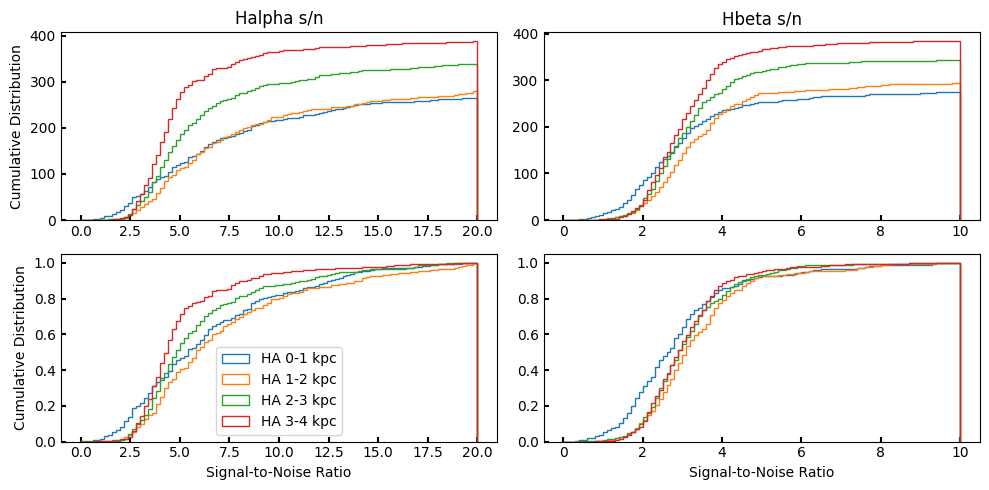

In [59]:
def bin_center(r_lis):
    diff = np.diff(r_lis)  # Calculate differences between consecutive elements
    diff = diff[diff > 0]  # Keep only positive differences
    return r_lis + np.mean(diff) / 2  # Return r_lis plus half the mean of the differences

#immittate the pixel level s.n histogram to plot s/n for annulei photometry
obj_lis = Table.read('obj_lis_selected.fits')
obj_lis = obj_lis[obj_lis['manual_select']=='keep']
sn_ha = np.array([])
sn_hb = np.array([])
r_lis = np.array([])
for obj in tqdm(obj_lis):
    try:
        path = f"data_extracted/{file_name(obj, prefix='extracted')}"
        with fits.open(path) as hdu:
                data = find_data('RAD_PROFILE_ELLIP', hdu)[1].data
                r, ha_r, ha_r_err, hb_r, hb_r_err, balmer_r, balmer_r_err, E_ba, A_a = np.vstack(data).transpose()
                r_center = bin_center(r)
                r_lis = np.append(r_lis, r_center)
                sn_ha = np.append(sn_ha, ha_r / ha_r_err)
                sn_hb = np.append(sn_hb, hb_r / hb_r_err)
    except Exception as e:
        print(f"Error processing {obj['subfield']}-{obj['ID']}: {e}")
        continue

plt.figure(figsize=(10, 5))
#first subplot
for r_range in [[0,1],[1,2],[2,3],[3,4]]:
    mask = (r_lis >= r_range[0]) & (r_lis < r_range[1])
    plt.subplot(2, 2, 1)
    plt.title('Halpha s/n')
    plt.hist(sn_ha[mask], bins=100, cumulative=True, histtype='step', label=f'HA {r_range[0]}-{r_range[1]} kpc',range=(0,20))#,density=True)
    plt.ylabel('Cumulative Distribution')

    plt.subplot(2,2,3)
    plt.hist(sn_ha[mask], bins=100, cumulative=True, histtype='step', label=f'HA {r_range[0]}-{r_range[1]} kpc',range=(0,20),density=True)
plt.legend()

plt.xlabel('Signal-to-Noise Ratio')
plt.ylabel('Cumulative Distribution')
#second subplot
for r_range in [[0,1],[1,2],[2,3],[3,4]]:
    mask = (r_lis >= r_range[0]) & (r_lis < r_range[1])
    plt.subplot(2, 2, 2)
    plt.title('Hbeta s/n')
    plt.hist(sn_hb[mask], bins=100, cumulative=True, histtype='step', label=f'HB {r_range[0]}-{r_range[1]} kpc',range=(0,10))#,density=True)
    plt.subplot(2,2,4)
    plt.hist(sn_hb[mask], bins=100, cumulative=True, histtype='step', label=f'HB {r_range[0]}-{r_range[1]} kpc',range=(0,10),density=True)
plt.xlabel('Signal-to-Noise Ratio')
plt.tight_layout()


  0%|          | 0/93 [00:00<?, ?it/s]

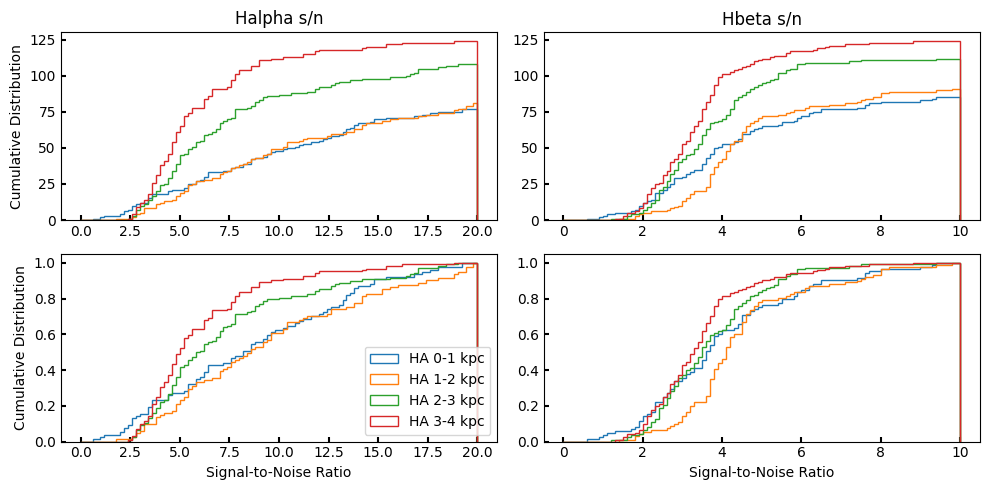

In [56]:
def bin_center(r_lis):
    diff = np.diff(r_lis)  # Calculate differences between consecutive elements
    diff = diff[diff > 0]  # Keep only positive differences
    return r_lis + np.mean(diff) / 2  # Return r_lis plus half the mean of the differences

#immittate the pixel level s.n histogram to plot s/n for annulei photometry
obj_lis = Table.read('obj_lis_selected.fits')
obj_lis = obj_lis[obj_lis['manual_select']=='keep']
obj_lis = obj_lis[(obj_lis['sn_ha'] > 0) & (obj_lis['sn_hb'] > 5)]
sn_ha = np.array([])
sn_hb = np.array([])
r_lis = np.array([])
for obj in tqdm(obj_lis):
    try:
        path = f"data_extracted/{file_name(obj, prefix='extracted')}"
        with fits.open(path) as hdu:
                data = find_data('RAD_PROFILE_ELLIP', hdu)[1].data
                r, ha_r, ha_r_err, hb_r, hb_r_err, balmer_r, balmer_r_err, E_ba, A_a = np.vstack(data).transpose()
                r_center = bin_center(r)
                r_lis = np.append(r_lis, r_center)
                sn_ha = np.append(sn_ha, ha_r / ha_r_err)
                sn_hb = np.append(sn_hb, hb_r / hb_r_err)
    except Exception as e:
        print(f"Error processing {obj['subfield']}-{obj['ID']}: {e}")
        continue

plt.figure(figsize=(10, 5))
#first subplot
for r_range in [[0,1],[1,2],[2,3],[3,4]]:
    mask = (r_lis >= r_range[0]) & (r_lis < r_range[1])
    plt.subplot(2, 2, 1)
    plt.title('Halpha s/n')
    plt.hist(sn_ha[mask], bins=100, cumulative=True, histtype='step', label=f'HA {r_range[0]}-{r_range[1]} kpc',range=(0,20))#,density=True)
    plt.ylabel('Cumulative Distribution')

    plt.subplot(2,2,3)
    plt.hist(sn_ha[mask], bins=100, cumulative=True, histtype='step', label=f'HA {r_range[0]}-{r_range[1]} kpc',range=(0,20),density=True)
plt.legend()

plt.xlabel('Signal-to-Noise Ratio')
plt.ylabel('Cumulative Distribution')
#second subplot
for r_range in [[0,1],[1,2],[2,3],[3,4]]:
    mask = (r_lis >= r_range[0]) & (r_lis < r_range[1])
    plt.subplot(2, 2, 2)
    plt.title('Hbeta s/n')
    plt.hist(sn_hb[mask], bins=100, cumulative=True, histtype='step', label=f'HB {r_range[0]}-{r_range[1]} kpc',range=(0,10))#,density=True)
    plt.subplot(2,2,4)
    plt.hist(sn_hb[mask], bins=100, cumulative=True, histtype='step', label=f'HB {r_range[0]}-{r_range[1]} kpc',range=(0,10),density=True)
plt.xlabel('Signal-to-Noise Ratio')
plt.tight_layout()

## making diagnostic plots

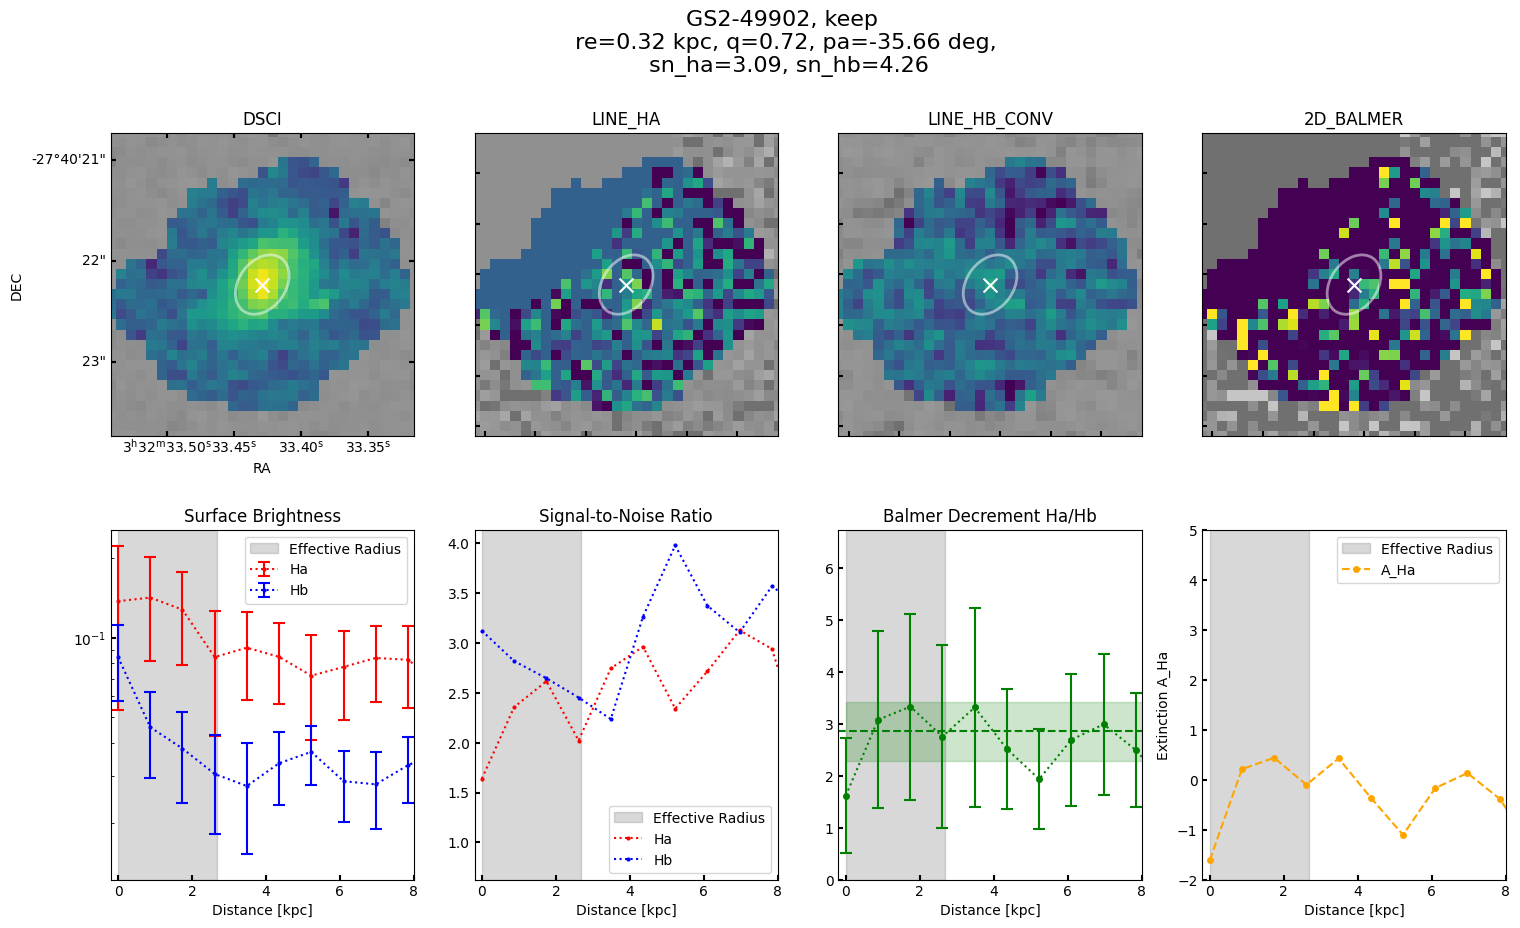

In [ ]:
from astropy.visualization import ImageNormalize, PercentileInterval, AsinhStretch
from matplotlib import cm
from photutils.aperture import EllipticalAperture
%matplotlib inline
obj_lis = Table.read('obj_lis_selected.fits')
obj_lis = obj_lis[obj_lis['manual_select']=='keep']
#plot 4x2 images 1st row: imshow ['DSCI', 'LINE_HA', 'LINE_HB_CONV', '2D_BALMER']
#2nd row: imshow I will do later

def make_diagnostic_plots(obj):
        try:
            plt.figure(figsize=(18,10))
            #set the title, re q pa, sn_ha sn_hb
            plt.suptitle(f"{obj['subfield']}-{obj['ID']}, {obj['manual_select']} \n re={obj['re']:.2f} kpc, q={obj['q']:.2f}, pa={obj['pa']:.2f} deg, \n sn_ha={obj['sn_ha']:.2f}, sn_hb={obj['sn_hb']:.2f}", fontsize=16)
            #tight layout
            plt.tight_layout()
            #set default tick parameter: all ticks sticks inside all axes
            matplotlib.rcParams['xtick.direction'] = 'in'
            matplotlib.rcParams['ytick.direction'] = 'in'
            #make tick thick
            matplotlib.rcParams['xtick.major.width'] = 1.5
            matplotlib.rcParams['ytick.major.width'] = 1.5
            path = f"data_extracted/{file_name(obj, prefix='extracted')}"
            with fits.open(path) as hdu:
                #find segmentation map
                seg = find_data('SEG', hdu)[1].data == obj['ID']

                #store the effective radius, position angle and axis ratio
                re = obj['re']/0.1; q = obj['q']; pa = obj['pa']

                for i,name in enumerate(['DSCI', 'LINE_HA', 'LINE_HB_CONV', '2D_BALMER']):
                    #also embed wcs informatin
                    #use astropy visulalization to plot the image and also stretch the image
                    if i+1 == 1:
                        ax = plt.subplot(2, 4, i+1,projection=WCS(hdu[3].header))
                        ax.set_xlabel('RA')
                        ax.set_ylabel('DEC')
                    else:
                        ax = plt.subplot(2, 4, i+1)
                        ax.set_xticklabels([])
                        ax.set_yticklabels([])

                    data = find_data(name, hdu)[1].data
                    

                    if name == '2D_BALMER':
                        # for 2D_BALMER, we normalize value limits from 0 to 15
                        norm = ImageNormalize(data, vmin=0, vmax=15, stretch=AsinhStretch())
                    else:
                        norm = ImageNormalize(find_data('DSCI',hdu)[1].data, interval=PercentileInterval(100), stretch=AsinhStretch())
                    
                    #plot the segmentation map
                    # get the viridis colormap and convert to grayscale
                    # Convert the viridis colormap to greyscale by averaging the RGB channels
                    viridis_cmap = cm.get_cmap('viridis')
                    grey_viridis_cmap = cm.colors.ListedColormap(
                        np.mean(viridis_cmap(np.linspace(0, 1, 256))[:, :3], axis=1, keepdims=True).repeat(3, axis=1))
                    grey_viridis_cmap._init()

                    ax.imshow(np.where(seg,data,np.nan), origin='lower', norm=norm, cmap='viridis')
                    ax.imshow(np.where(~seg, data, np.nan), origin='lower', norm=norm, cmap=grey_viridis_cmap, alpha=0.7)
                    #set the title
                    ax.set_title(f"{name}")

                    #plot the ellipse at the effective radius for all images, use photutils aperture
                    # Center in the cropped image
                    center = ((data.shape[1]-2)/2, (data.shape[0]-2)/2)
                    # EllipticalAperture: (x, y), a, b, theta (in radians)
                    aperture = EllipticalAperture(center, a=re, b=re * q, theta=np.deg2rad(pa*u.deg - 90*u.deg))
                    aperture.plot(ax=ax, color='white', lw=2,alpha=0.5, label='Effective Radius')
                    ax.scatter(center[1], center[0], color='white', s=100, marker='x', label='Center')

                    # Set the axis limits to center a 30x30 region around the image center
                    y, x = center
                    ax.set_xlim(x - 15, x + 15)
                    ax.set_ylim(y - 15, y + 15)


                r, ha_r, ha_r_err, hb_r, hb_r_err, balmer_r, balmer_r_err, E_BV, A_Ha = np.vstack(find_data('RAD_PROFILE_ELLIP', hdu)[1].data).transpose()
                #in the following 4 subplots we plot:
                #  1 radial profile (errorbars) of ha,hb together
                #  2 radial profile (errorbars) of s/n of ha,hb together
                #  3 radial profile of balmer decrement, with right y-axis showing the extinction (this plot covers the 7,8 subplots)

                #plot the radial profile of ha and hb
                ax = plt.subplot(2, 4, 5)
                
                #plot a grey area representing the effective radius
                ax.axvspan(0, re*obj['pixel_length'], color='grey', alpha=0.3, label='Effective Radius')
                ax.errorbar(
                    r, ha_r, yerr=ha_r_err, label='Ha', fmt='o:', color='red', markersize=2,
                    capsize=4, capthick=1.5, elinewidth=1.5
                )
                ax.errorbar(
                    r, hb_r, yerr=hb_r_err, label='Hb', fmt='o:', color='blue', markersize=2,
                    capsize=4, capthick=1.5, elinewidth=1.5
                )
                ax.set_xlim(-0.2, 8)
                ax.set_xlabel('Distance [kpc]')
                ax.set_title('Surface Brightness')
                ax.set_yscale('log')
                ax.legend()

                #plot the radial profile of ha and hb s/n
                ax = plt.subplot(2, 4, 6)
                ax.axvspan(0, re*obj['pixel_length'], color='grey', alpha=0.3, label='Effective Radius')
                ax.errorbar(r, ha_r / ha_r_err, label='Ha', fmt='o:', color='red', markersize=2)
                ax.errorbar(r, hb_r / hb_r_err, label='Hb', fmt='o:', color='blue', markersize=2)
                ax.set_xlim(-0.2, 8)
                ax.set_xlabel('Distance [kpc]')
                ax.set_title('Signal-to-Noise Ratio')
                ax.legend()

                #plot the radial profile of balmer decrement
                ax = plt.subplot(2, 4, 7)
                ax.axvspan(0, re*obj['pixel_length'], color='grey', alpha=0.3, label='Effective Radius')
                ax.errorbar(
                    r, balmer_r, yerr=balmer_r_err, label='Balmer Decrement',
                    fmt='o:', color='green', markersize=4,
                    capsize=4, capthick=1.5, elinewidth=1.5
                )
                ax.axhline(y=2.86, color='green', linestyle='--', label='theory')
                ax.fill_between(r, 2.86*0.8, 2.86*1.2, color='green', alpha=0.2)
                ax.set_xlim(-0.2, 8)
                ax.set_ylim(0, np.nanmin([np.nanmax(balmer_r)+3,25]))
                ax.set_xlabel('Distance [kpc]')
                ax.set_title('Balmer Decrement Ha/Hb')

                #plot the extinction A_Ha
                ax = plt.subplot(2, 4, 8)
                ax.axvspan(0, re*obj['pixel_length'], color='grey', alpha=0.3, label='Effective Radius')
                ax.plot(r, A_Ha, label='A_Ha', color='orange', linestyle='--',marker='o', markersize=4)
                ax.set_xlim(-0.2, 8)
                ax.set_xlabel('Distance [kpc]')
                ax.set_ylabel('Extinction A_Ha')
                ax.set_ylim(-2, 5)
                ax.legend(loc='upper right')
                ax.legend()
        except Exception as e:
            print(f"Error processing {obj['subfield']}-{obj['ID']}: {e}")

def main():
    os.makedirs('diagnostic_plots', exist_ok=True)
    os.makedirs('sn0_2', exist_ok=True)
    os.makedirs('sn2_4', exist_ok=True)
    os.makedirs('sn5_10', exist_ok=True)
    os.makedirs('sn10', exist_ok=True)
    for obj in tqdm(Table.read('obj_lis_selected.fits')[Table.read('obj_lis_selected.fits')['manual_select']=='keep']):
        make_diagnostic_plots(obj)
        if obj['sn_ha'] < 2 and obj['sn_hb'] < 2:
            plt.savefig(f'sn0_2/{file_name(obj,prefix="diag")}.png', dpi=300, bbox_inches='tight')
        elif obj['sn_ha'] < 4 and obj['sn_hb'] < 4:
            plt.savefig(f'sn3_4/{file_name(obj,prefix="diag")}.png', dpi=300, bbox_inches='tight')
        elif obj['sn_ha'] < 10 and obj['sn_hb'] < 10:
            plt.savefig(f'sn5_10/{file_name(obj,prefix="diag")}.png', dpi=300, bbox_inches='tight')
        else:
            plt.savefig(f'sn10/{file_name(obj,prefix="diag")}.png', dpi=300, bbox_inches='tight')
        plt.show()
        clear_output(wait=True)
main()

Processing GN7-13686


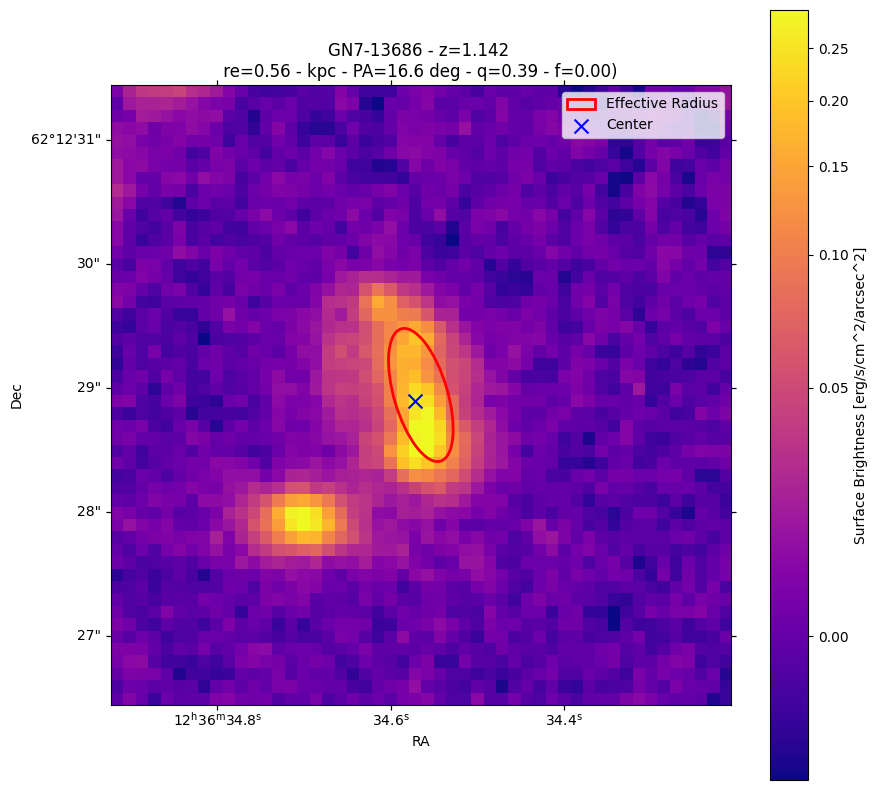

In [ ]:
from astropy.wcs.utils import pixel_to_skycoord
from astropy.visualization import (ImageNormalize, PercentileInterval, AsinhStretch)
from astropy.coordinates import SkyCoord
%matplotlib inline
obj_lis = Table.read('obj_lis_selected.fits')
#while True:
if True:
    for obj in tqdm(obj_lis[:10]):
    #for obj in obj_lis:
        try:
            print(f"Processing {obj['subfield']}-{obj['ID']}")
            # 先定义 re, pa, q
            re = obj['re']
            pa = obj['pa']
            q  = obj['q']
            with fits.open(f"data_extracted/{file_name(obj,prefix='extracted')}") as hdu:
                linemap = find_data('DSCI', hdu)[1]
                r, final_apertures = ellip_aperture_series(obj, linemap)
                img = find_data('DSCI', hdu)[1].data
                try:
                    wcs = WCS(find_data('DSCI', hdu)[1].header)
                except Exception:
                    wcs = None

                norm = ImageNormalize(img, interval=PercentileInterval(99.5), stretch=AsinhStretch())
                plt.figure(figsize=(10, 10))
                if wcs is not None and wcs.has_celestial:
                    ax = plt.subplot(projection=wcs)
                    im = ax.imshow(img, cmap='plasma', norm=norm)
                    ax.set_xlabel('RA')
                    ax.set_ylabel('Dec')
                else:
                    ax = plt.gca()
                    im = ax.imshow(img , cmap='plasma', norm=norm)
                    ax.set_xlabel('X [pixels]')
                    ax.set_ylabel('Y [pixels]')
                plt.colorbar(im, ax=ax, label='Surface Brightness [erg/s/cm^2/arcsec^2]')
                
                plt.title(f"{obj['subfield']}-{obj['ID']} - z={obj['z_MAP']:.3f} \n re={re:.2f} - kpc - PA={pa:.1f} deg - q={q:.2f} - f={obj['f']:.2f}) ")

                # plot the ellipse in effective radius
                #re = 1
                #q = 0.5
                #pa = 30
                ellipse = EllipticalAperture(
                    ((linemap.data.shape[1]-2) / 2, (linemap.data.shape[0]-2) / 2),
                    re / 0.1, 
                    re * q / 0.1, 
                    theta = -(90 -pa) * u.deg   # 修正，保证和PA箭头一致
                )
                ellipse.plot(color='red', lw=2, label='Effective Radius')
                center_x = (linemap.data.shape[1]-2) / 2
                center_y = (linemap.data.shape[0]-2) / 2
                ax.scatter(center_x, center_y, color='blue', marker='x', s=100, label='Center')

                plt.legend()
                #plt.savefig(f'morph_test/{obj["subfield"]}-{obj["ID"]}_morph.png', bbox_inches='tight')
                plt.show()
                sleep(0.5)
                clear_output(wait=True)
                gc.collect()
        except Exception as e:
            print(f"Error processing {obj['subfield']}-{obj['ID']}: {e}")
            continue

In [4]:
obj_lis

ID,RA_1,DEC_1,nlines,z_50,z_02,z_16,z_84,z_97,z_MAP,z_RISK,ArIII-7138_FLUX,ArIII-7138_FLUX_ERR,ArIII-7138_EW_RF_16,ArIII-7138_EW_RF_50,ArIII-7138_EW_RF_84,CIII-1908_FLUX,CIII-1908_FLUX_ERR,CIII-1908_EW_RF_16,CIII-1908_EW_RF_50,CIII-1908_EW_RF_84,CIV-1549_FLUX,CIV-1549_FLUX_ERR,CIV-1549_EW_RF_16,CIV-1549_EW_RF_50,CIV-1549_EW_RF_84,H8_FLUX,H8_FLUX_ERR,H8_EW_RF_16,H8_EW_RF_50,H8_EW_RF_84,H9_FLUX,H9_FLUX_ERR,H9_EW_RF_16,H9_EW_RF_50,H9_EW_RF_84,Ha_FLUX,Ha_FLUX_ERR,Ha_EW_RF_16,Ha_EW_RF_50,Ha_EW_RF_84,Hb_FLUX,Hb_FLUX_ERR,Hb_EW_RF_16,Hb_EW_RF_50,Hb_EW_RF_84,Hd_FLUX,Hd_FLUX_ERR,Hd_EW_RF_16,Hd_EW_RF_50,Hd_EW_RF_84,HeI-1083_FLUX,HeI-1083_FLUX_ERR,HeI-1083_EW_RF_16,HeI-1083_EW_RF_50,HeI-1083_EW_RF_84,HeI-5877_FLUX,HeI-5877_FLUX_ERR,HeI-5877_EW_RF_16,HeI-5877_EW_RF_50,HeI-5877_EW_RF_84,HeII-1640_FLUX,HeII-1640_FLUX_ERR,HeII-1640_EW_RF_16,HeII-1640_EW_RF_50,HeII-1640_EW_RF_84,Hg_FLUX,Hg_FLUX_ERR,Hg_EW_RF_16,Hg_EW_RF_50,Hg_EW_RF_84,Lya_FLUX,Lya_FLUX_ERR,Lya_EW_RF_16,Lya_EW_RF_50,Lya_EW_RF_84,MgII_FLUX,MgII_FLUX_ERR,MgII_EW_RF_16,MgII_EW_RF_50,MgII_EW_RF_84,NIII-1750_FLUX,NIII-1750_FLUX_ERR,NIII-1750_EW_RF_16,NIII-1750_EW_RF_50,NIII-1750_EW_RF_84,NIV-1487_FLUX,NIV-1487_FLUX_ERR,NIV-1487_EW_RF_16,NIV-1487_EW_RF_50,NIV-1487_EW_RF_84,NV-1240_FLUX,NV-1240_FLUX_ERR,NV-1240_EW_RF_16,NV-1240_EW_RF_50,NV-1240_EW_RF_84,NeIII-3867_FLUX,NeIII-3867_FLUX_ERR,NeIII-3867_EW_RF_16,NeIII-3867_EW_RF_50,NeIII-3867_EW_RF_84,NeV-3346_FLUX,NeV-3346_FLUX_ERR,NeV-3346_EW_RF_16,NeV-3346_EW_RF_50,NeV-3346_EW_RF_84,NeVI-3426_FLUX,NeVI-3426_FLUX_ERR,NeVI-3426_EW_RF_16,NeVI-3426_EW_RF_50,NeVI-3426_EW_RF_84,OI-6302_FLUX,OI-6302_FLUX_ERR,OI-6302_EW_RF_16,OI-6302_EW_RF_50,OI-6302_EW_RF_84,OII_FLUX,OII_FLUX_ERR,OII_EW_RF_16,OII_EW_RF_50,OII_EW_RF_84,OII-7325_FLUX,OII-7325_FLUX_ERR,OII-7325_EW_RF_16,OII-7325_EW_RF_50,OII-7325_EW_RF_84,OIII_FLUX,OIII_FLUX_ERR,OIII_EW_RF_16,OIII_EW_RF_50,OIII_EW_RF_84,OIII-1663_FLUX,OIII-1663_FLUX_ERR,OIII-1663_EW_RF_16,OIII-1663_EW_RF_50,OIII-1663_EW_RF_84,OIII-4363_FLUX,OIII-4363_FLUX_ERR,OIII-4363_EW_RF_16,OIII-4363_EW_RF_50,OIII-4363_EW_RF_84,PaB_FLUX,PaB_FLUX_ERR,PaB_EW_RF_16,PaB_EW_RF_50,PaB_EW_RF_84,SII_FLUX,SII_FLUX_ERR,SII_EW_RF_16,SII_EW_RF_50,SII_EW_RF_84,SIII_FLUX,SIII_FLUX_ERR,SIII_EW_RF_16,SIII_EW_RF_50,SIII_EW_RF_84,HeII-4687_FLUX,HeII-4687_FLUX_ERR,HeII-4687_EW_RF_16,HeII-4687_EW_RF_50,HeII-4687_EW_RF_84,T_G102,T_G141,BIC_TEMP,CHIMIN,DOF,subfield,id,ra,dec,z_spec,nusefilt,lc_min,lc_max,z_phot,z_phot_chi2,z_phot_risk,z_min_risk,min_risk,z_raw_chi2,raw_chi2,z025,z160,z500,z840,z975,restU,restU_err,restB,restB_err,restV,restV_err,restJ,restJ_err,dL,mass,sfr,Lv,LIR,MLv,Av,mass_p,sfr_p,Lv_p,LIR_p,ssfr_p,rest270,rest270_err,rest274,rest274_err,rest120,rest120_err,rest121,rest121_err,rest156,rest156_err,rest157,rest157_err,rest158,rest158_err,rest159,rest159_err,rest160,rest160_err,rest161,rest161_err,rest162,rest162_err,rest163,rest163_err,DISTMOD,ABSM_271,ABSM_272,ABSM_274,NUMBER,RA_2,DEC_2,f,mag,dmag,re,dre,n,dn,q,dq,pa,dpa,sn,field,sn_ha,sn_hb,tag,manual_select,pixel_length
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,Mpc,solMass,solMass / yr,solLum,solLum,solMass / solLum,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
int32,float64,float64,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,flo